In [1]:
# Import dependencies
import os
import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RescaleAction
from gymnasium.envs import register

import torch

import ray
from ray import tune
from ray.tune.registry import register_env
from ray.air import RunConfig
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig

from scipy.spatial.transform import Rotation as R

from ray import air
from ray import tune

# Import modules
from Environment_Creator import env_creator

### PPO Hyperparameters

| Parameter          | Value   | Why?                                                                 |
|--------------------|---------|----------------------------------------------------------------------|
| learning_rate      | 1e-4    | Lower LR: More stable learning for physics-based problems.           |
| n_steps            | 2048    | Large: Helps PPO collect enough experience before updates.           |
| batch_size         | 256     | Large: Improves stability of gradient updates.                       |
| n_epochs           | 10      | Higher: More passes over data to improve policy update efficiency.   |
| gamma              | 0.999   | High: Spacecraft tasks require long-term planning.                   |
| gae_lambda         | 0.95    | Standard: Smooths advantage estimation for stable learning.          |
| clip_range         | 0.2     | Default: Helps prevent overly large updates.                         |
| ent_coef           | 0.01    | Encourages exploration: Spacecraft may need to explore better trajectories. |
| vf_coef            | 0.5     | Default: Keeps value loss balanced with policy loss.                 |
| max_grad_norm      | 0.5     | Prevents exploding gradients: Important for stable learning.         |
| target_kl          | 0.02    | New!: Limits how much the policy can change per step (avoids instability). |




In [2]:
config = None

Doc basic test:

In [5]:
from SpacecraftOrbitalEnv import SpacecraftOrbitalEnv

config = (
    PPOConfig()
    .environment(
        SpacecraftOrbitalEnv,
        env_config={},  # `config` to pass to env class 
    )
    .env_runners(num_env_runners=2)
    .training(gamma=0.9, lr=0.01, train_batch_size_per_learner=1000)
)

results = tune.Tuner(
    "PPO",
    run_config=air.RunConfig(stop={"training_iteration": 1000}),
    param_space=config,
).fit()

2025-02-09 16:55:01,065	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-02-09 16:55:01,067	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-02-09 17:45:37,249	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last t

In [7]:
# Get the best result based on a particular metric.
best_result = results.get_best_result(
    metric="env_runners/episode_return_mean", mode="max"
)
best_checkpoint = best_result.checkpoint

In [8]:
algo = Algorithm.from_checkpoint(best_checkpoint.path)

AttributeError: 'NoneType' object has no attribute 'path'

In [9]:
# Access the metrics dataframe
metrics_df = best_result.metrics_dataframe

In [10]:
metrics_df

,num_training_step_calls_per_iteration,num_env_steps_sampled_lifetime,num_env_steps_sampled_lifetime_throughput,done,training_iteration,trial_id,date,timestamp,time_this_iter_s,time_total_s,...,config/input,config/policies/default_policy,config/callbacks,config/create_env_on_driver,config/custom_eval_function,config/framework,perf/cpu_util_percent,perf/ram_util_percent,timers/synch_env_connectors,env_runners/time_between_sampling
0,1,1000,NaN,False,1,d669a_00000,2025-02-09_16-55-39,1739112939,5.138419,5.138419,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,20.787500,95.125000,NaN,NaN
1,1,2000,201.599998,False,2,d669a_00000,2025-02-09_16-55-44,1739112944,4.943134,10.081553,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,11.328571,90.557143,0.011968,3.618121
2,1,3000,198.755299,False,3,d669a_00000,2025-02-09_16-55-49,1739112949,4.994205,15.075757,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,11.185714,90.371429,0.012017,3.618113
3,1,4000,150.277489,False,4,d669a_00000,2025-02-09_16-55-56,1739112956,6.628961,21.704718,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,10.488889,90.300000,0.012034,3.618103
4,1,5000,158.540851,False,5,d669a_00000,2025-02-09_16-56-02,1739112962,6.277825,27.982543,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,11.955556,88.500000,0.012040,3.618423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,1,430000,136.661575,False,430,d669a_00000,2025-02-09_17-45-05,1739115905,7.299656,2958.987049,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,9.240000,68.690000,0.013292,5.807051
430,1,431000,136.117136,False,431,d669a_00000,2025-02-09_17-45-12,1739115912,7.321261,2966.308309,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,9.670000,68.680000,0.013315,5.809951
431,1,432000,137.828369,False,432,d669a_00000,2025-02-09_17-45-20,1739115920,7.225399,2973.533708,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,9.840000,68.690000,0.013311,5.812807
432,1,433000,133.482970,False,433,d669a_00000,2025-02-09_17-45-27,1739115927,7.460054,2980.993762,...,sampler,"[None, None, None, None]",<class 'ray.rllib.callbacks.callbacks.RLlibCal...,False,None,torch,8.900000,68.618182,0.013319,5.815600


In [11]:
# Print or inspect the metrics
print(metrics_df.head())

   num_training_step_calls_per_iteration  num_env_steps_sampled_lifetime  \
0                                      1                            1000   
1                                      1                            2000   
2                                      1                            3000   
3                                      1                            4000   
4                                      1                            5000   

   num_env_steps_sampled_lifetime_throughput   done  training_iteration  \
0                                        NaN  False                   1   
1                                 201.599998  False                   2   
2                                 198.755299  False                   3   
3                                 150.277489  False                   4   
4                                 158.540851  False                   5   

      trial_id                 date   timestamp  time_this_iter_s  \
0  d669a_00000  2025-02

In [12]:
metrics_df["training_iteration"]

0        1
1        2
2        3
3        4
4        5
      ... 
429    430
430    431
431    432
432    433
433    434
Name: training_iteration, Length: 434, dtype: int64

In [13]:
metrics_df["env_runners/episode_return_mean"]

0      7708.934307
1      7088.458712
2      6798.964503
3      6640.429388
4      6418.149181
          ...     
429    5736.994787
430    5736.993004
431    5736.993926
432    5736.993188
433    5736.991652
Name: env_runners/episode_return_mean, Length: 434, dtype: float64

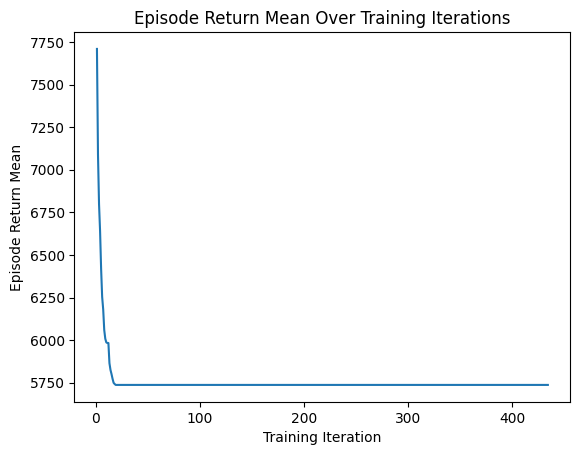

In [14]:
# Plot key metrics
import matplotlib.pyplot as plt

# Example: Plot episode return mean over training iterations
plt.plot(metrics_df["training_iteration"], metrics_df["env_runners/episode_return_mean"])
plt.xlabel("Training Iteration")
plt.ylabel("Episode Return Mean")
plt.title("Episode Return Mean Over Training Iterations")
plt.show()

In [15]:
policy = algo.get_policy()

NameError: name 'algo' is not defined